# CNN evaluation and predictions

<br>This notebook shows how the CNN models can be used for predicting the centers of the particles with the trained models. 
<br> You can use these examples modules to extract particle centres and check the quality of the predictions via the metrics
<br> The model used here is fully trained.

Finally there is a code for computing the metrics: accuracy and F1 score.

In [1]:
# load the python modules 
from pathlib import Path
import numpy as np 
import torch
import cv2
import glob
import matplotlib.pyplot as plt 

# import the user defined modules
from utils.coord_htmp_exchange import image2coord
from utils.config_utils import load_config
from utils.visualizations import visualise_detection
from utils.metrics import metrics

# import the models
from models import UNetHeatmap

In [2]:
# ........... build the path architecture ........ 
cwd = Path().resolve() 
Parent = cwd.parent
# set file path architecture from the yaml file. 
path_data = load_config(str(cwd.parent / 'configs/config.yaml'))
# path to the image stock (... path the data warehouse ......)
stock_image_dir =cwd.parent / path_data['Images']['Unlabelled_stock']
# path to store the predicted heatmap
heatmaps_pred_w_err_dir = cwd.parent / path_data['Heatmaps']['Errored_HumanOL']
# path to store the images used for prediction 
images_pred_w_err_dir = cwd.parent / path_data['Images']['Errored_HumanOL']
# path to the models
model_path =cwd.parent / path_data['Trained_Models']
# Extract a reference heatmap for ground truth example
heatmap_data_syn = cwd.parent /path_data['Heatmaps']['FirstTrain_syn']

In [3]:
# Set evaluate the model based on the proccessing unit available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = UNetHeatmap()
model = torch.load( str(model_path) + '\CNN_UNET_full_model_512.pth')
model.to(device)
_ = model.eval()

## Detect the particle centers with a image and evaluate the predictions

In [5]:
# define the constants
threshold = 20 #  percentage  
scan_radius = 2 # pixels

In [22]:
def image2coord(model, img_path, device, threshold = 20, scan_radius = 2):
    '''
    Takes the image and predicts the heatmap. Then extracts the postions from the heat map coordinates.
    Then finds the local maxima based on the threshold and the scan_radius
    
    Params: 
        model       : CNN model 
        img_path  : path to the image location 
        device      : processor: cpu, gpu
        threshold   : cutoff based on the bacnkground noise
        scan_radius : plateau size for the heatmap pulse
        
    Returns: 
        x: array of x coordinates
        y: array of y coordinates 
        
    '''
    model.to(device)
    model.eval()
    
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  
    
    # no need for the grad
    with torch.no_grad():
        HtMap_pred = model(img.unsqueeze(0).to(device))
    
    # converts to standard grey map and pushes the heatmap to the CPU 
    heatmap = HtMap_pred.squeeze().cpu().numpy()*255

    # Apply maximum filter
    max_filt = maximum_filter(heatmap, size=scan_radius, mode='constant')

    # Find pixels equal to local max
    local_max = (heatmap == max_filt)

    # Threshold for noise tolerance (same as max threshold in imageJ)
    detected_peaks = local_max & (heatmap > threshold)

    # Label connected components (plateaus)
    labeled, num_features = label(detected_peaks)

    # Get centroids of plateaus (peak positions)
    peak_coords = center_of_mass(heatmap, labeled, range(1, num_features+1))
    y, x =  np.array(peak_coords).transpose()
    
    # two vectors containing the x and the y coordinates
    return x, y, heatmap

In [24]:
stock_image_list = r'C:\Users\tosam\Dropbox\Q\New folder\000002.tif'
img = cv2.imread(stock_image_list, cv2.IMREAD_GRAYSCALE)/255

model.to(device)
model.eval()
    

img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  

# no need for the grad
with torch.no_grad():
    HtMap_pred = model(img.unsqueeze(0).to(device))

# converts to standard grey map and pushes the heatmap to the CPU 
heatmap = HtMap_pred.squeeze().cpu().numpy()*255

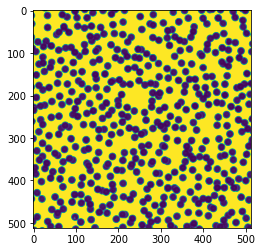

In [29]:
img = cv2.imread(stock_image_list, cv2.IMREAD_GRAYSCALE)/255
plt.imshow(img)

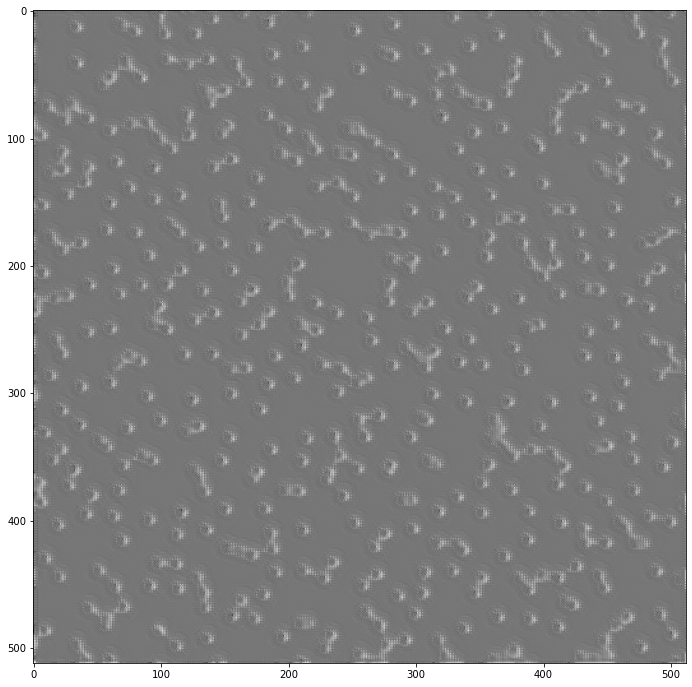

In [31]:
plt.figure(figsize = (12,12))
plt.imshow(heatmap, cmap = 'Greys')

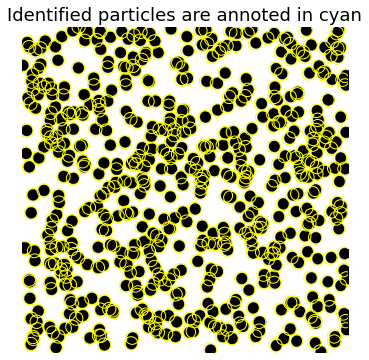

In [21]:
# import the image from the image stock
stock_image_list = glob.glob(str(stock_image_dir)+'\*')[0]
# extract the x and y coordinates
threshold  = 10 
x_coord, y_coord, heatmap = image2coord(model, stock_image_list, device, threshold, scan_radius = 2)

# Now lets annote the image with the detected particles 
visualise_detection(x_coord, y_coord, cv2.imread(stock_image_list, cv2.IMREAD_GRAYSCALE),180, 'yellow')

In [ ]:
stock_image_list = r'C:\Users\tosam\Dropbox\Q\New folder\000002.tif'
cv2.imread(stock_image_list, cv2.IMREAD_GRAYSCALE)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [12]:
# ..............if you have the ground truth coordinates of the images then you can skip this step .........
# now we extract the coordinates from the ground truth heatmap
# extract the ground truth 
ground_truth_coordinates = glob.glob (str(heatmap_data_syn) + '\*.npy')[0]
heatmap  = np.load(ground_truth_coordinates)

y_gt, x_gt = np.where(heatmap >=threshold/100) # threshold is converted into fractions

In [14]:
# create an object of teh metrics class and evaluate different metrics
metrics_obj = metrics( x_coord, y_coord, x_gt, y_gt)
metrics_obj.KNN_for_tagging()
print(metrics_obj.metrics())

{'precision': 0.995, 'recall': 0.948, 'F1': 0.971, 'accuracy': 0.943}


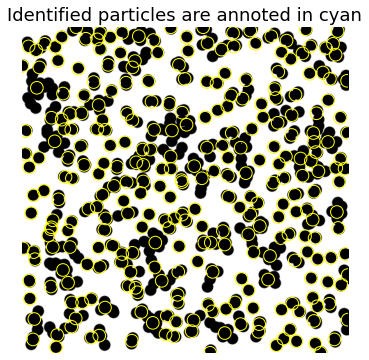

In [9]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
img = plt.imread(r'C:\Users\tosam\Dropbox\Q\New folder\000000.png')
coord = pd.read_csv(r'C:\Users\tosam\Dropbox\Q\results_512.tsv', sep = '\t')
visualise_detection(coord['X'].values, coord['Y'].values-2, img,160, 'Yellow')

In [28]:
metrics_obj1 = metrics( coord['X'].values, coord['Y'].values, x_gt, y_gt)
metrics_obj1.KNN_for_tagging()
print(metrics_obj1.metrics())

{'precision': 0.338, 'recall': 0.164, 'F1': 0.221, 'accuracy': 0.124}
